# Тема

В данной работе мы рассмотрим различные методы машинного обучения на примере 2х баз данных, одна из которых демонстрирует ингридиенты, которые используются в блюдах разных стран мира, а вторая - различные параметры вин

# Подключаем необходимые библиотеки

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## База данных, которую будем анализировать, скачана на мой компьютер, откроем её

In [2]:
with open('train.json') as data_file:    
    data = json.load(data_file)

In [4]:
data

[{'id': 10259,
  'cuisine': 'greek',
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']},
 {'id': 25693,
  'cuisine': 'southern_us',
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil']},
 {'id': 20130,
  'cuisine': 'filipino',
  'ingredients': ['eggs',
   'pepper',
   'salt',
   'mayonaise',
   'cooking oil',
   'green chilies',
   'grilled chicken breasts',
   'garlic powder',
   'yellow onion',
   'soy sauce',
   'butter',
   'chicken livers']},
 {'id': 22213,
  'cuisine': 'indian',
  'ingredients': ['water', 'vegetable oil', 'wheat', 'salt']},
 {'id': 13162,
  'cuisine': 'indian',
  'ingredients': ['black pepper',
   'shallots',
   'cornflour',
   'cayenne pepper',
   'onions',
   'garlic paste',
   'm

Приведём данные к нормальному виду:

In [5]:
products_num = np.array([len(i["ingredients"]) for i in data])

In [6]:
cuisine = []
ingredients = []
ingredients_num = []
for i in data:
    if len(i["ingredients"]) < 50:
        ingredients.append(" ".join(i["ingredients"]))
        cuisine.append(i["cuisine"])
        ingredients_num.append(len(i["ingredients"]))

In [7]:
df = pd.DataFrame()
df["cuisine"] = cuisine
df["ingridients"] = ingredients
df["ingredients_num"] = ingredients_num

In [11]:
df.head()

,cuisine,ingridients,ingredients_num
0,greek,romaine lettuce black olives grape tomatoes ga...,9
1,southern_us,plain flour ground pepper salt tomatoes ground...,11
2,filipino,eggs pepper salt mayonaise cooking oil green c...,12
3,indian,water vegetable oil wheat salt,4
4,indian,black pepper shallots cornflour cayenne pepper...,20


Посмотрим, сколько ингридиентов используется в блюдах разных стран, и отсортируем по убыванию

In [7]:
(df.groupby("cuisine")["ingredients_num"].mean().reset_index()
                                         .sort_values("ingredients_num", ascending=False))

,cuisine,ingredients_num
14,moroccan,12.909866
7,indian,12.705961
19,vietnamese,12.675152
2,cajun_creole,12.617076
18,thai,12.545809
10,jamaican,12.214829
3,chinese,11.982791
12,korean,11.284337
13,mexican,10.871058
17,spanish,10.423660


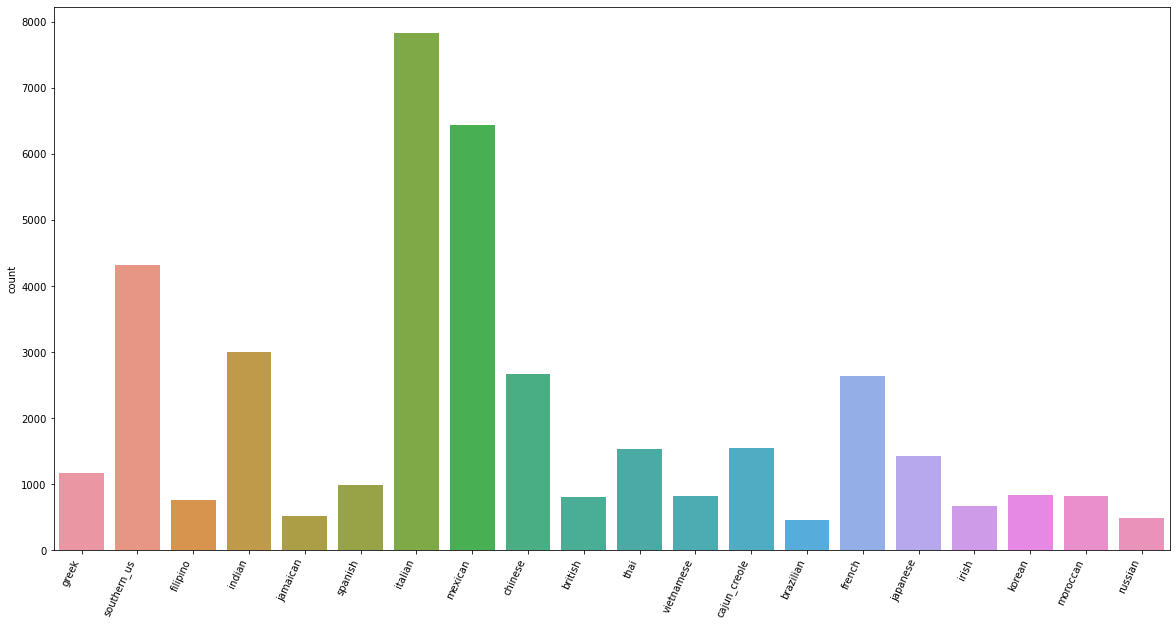

In [12]:
plt.figure(figsize=(20, 10))
chart = sns.countplot(cuisine)
ch = chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')

По данной таблице видно, что количество блюд из разных кухонь сильно разнится

## Преобразование данных

Преобразуем названия ингридиентов в векторный вид

In [13]:
vectorizer = TfidfVectorizer(min_df=10, max_df=0.5)

In [14]:
X = vectorizer.fit_transform(ingredients)

In [15]:
print(X.shape)

(39771, 1496)


In [16]:
LE = LabelEncoder()
labels = LE.fit_transform(cuisine)

In [17]:
labels

array([ 6, 16,  4, ...,  8,  3, 13], dtype=int64)

Разделим наш массив данных на тестовый и тренировочный и введём метрики, по которым будем подсчитывать точность работы моделей

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

In [22]:
def print_metrics(y_test, ans):
    print ("Accuracy ~", np.round(accuracy_score(y_test, ans), 4))
    print ("F1_score ~", np.round(f1_score(y_test, ans, average="macro"), 4))

# Сравнение моделей

# LR

In [23]:
LR = LogisticRegression(solver='liblinear')
LR.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [24]:
lr_ans = LR.predict(X_test)

In [25]:
print_metrics(y_test, lr_ans)

Accuracy ~ 0.7794
F1_score ~ 0.6871


Результат получился не очень хорошим. Попробуем другую модель.

# RF

In [26]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train, y_train.ravel())

RandomForestClassifier()

In [27]:
RF_ans = RF.predict(X_test)

In [28]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7461
F1_score ~ 0.6462


Результат не сильно отличается от логистической регрессии, а даже хуже. Однако теперь попробуем воспользоваться стэкингом и используем предсказания ил LR для улучшения предсказания нашей модели

In [29]:
X_train.shape

(26646, 1496)

In [30]:
LR.predict_proba(X_train).shape

(26646, 20)

In [31]:
RF_stack = RandomForestClassifier(n_estimators=100)
RF_stack.fit(np.hstack((X_train.toarray(), LR.predict_proba(X_train))), y_train.ravel())

RandomForestClassifier()

In [32]:
np.hstack((X_train.toarray(), LR.predict_proba(X_train))).shape

(26646, 1516)

In [33]:
LR.predict_proba(X_train)[0]

array([0.03129436, 0.00115313, 0.63886794, 0.01682681, 0.01810761,
       0.0065804 , 0.00678098, 0.00456652, 0.00124374, 0.00601469,
       0.00597156, 0.00336743, 0.00295572, 0.02737459, 0.00356044,
       0.00277191, 0.18483388, 0.0232924 , 0.0081036 , 0.00633228])

In [43]:
RF_ans_stack = RF_stack.predict(np.hstack((X_test.toarray(), LR.predict_proba(X_test))))


In [44]:
print_metrics(y_test, RF_ans_stack)

Accuracy ~ 0.7945
F1_score ~ 0.7152


Отлично, видим, что показатели улучшились, а значит, стэкинг действительно улучшил наши модели. Теперь мы рассмотрим, что такое bootstrap.

# Bootstrap

Для начала, взглянем на распределения двух кухонь: Русской и Бразильской:

In [46]:
df["cuisine"].value_counts()

italian         7837
mexican         6437
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        466
Name: cuisine, dtype: int64

In [47]:
cuisine1 = "russian"
cuisine2 = "brazilian"

In [48]:
cuisine1_df = df[df["cuisine"] == cuisine1]
cuisine2_df = df[df["cuisine"] == cuisine2]

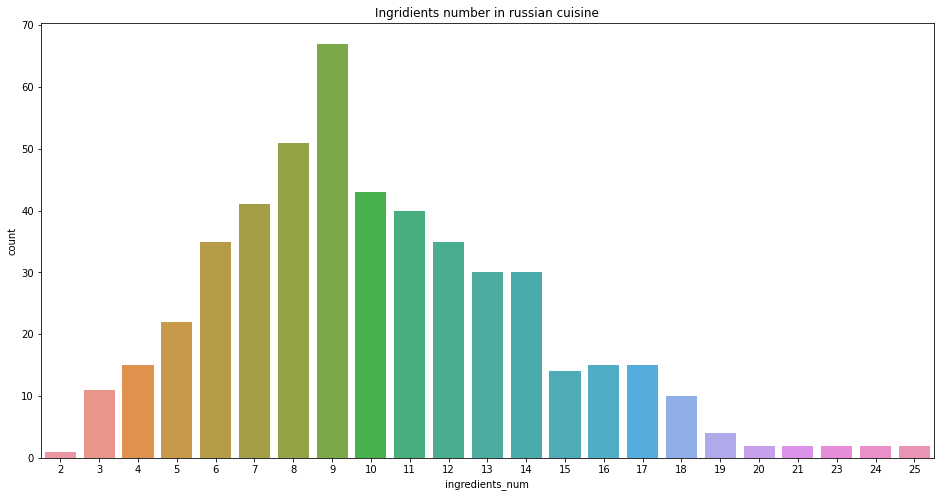

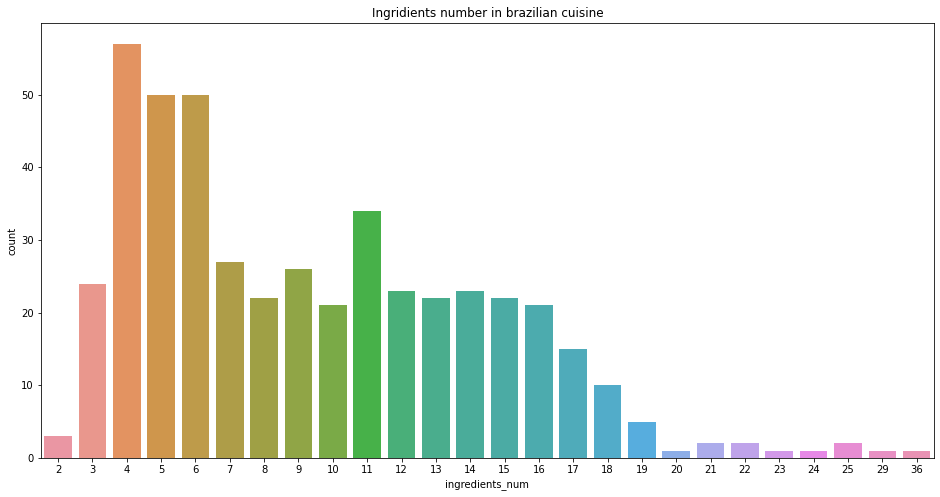

In [49]:
plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine1))
sns.countplot(cuisine1_df["ingredients_num"])

plt.figure(figsize=(16, 8))
plt.title("Ingridients number in {} cuisine".format(cuisine2))
sns.countplot(cuisine2_df["ingredients_num"])

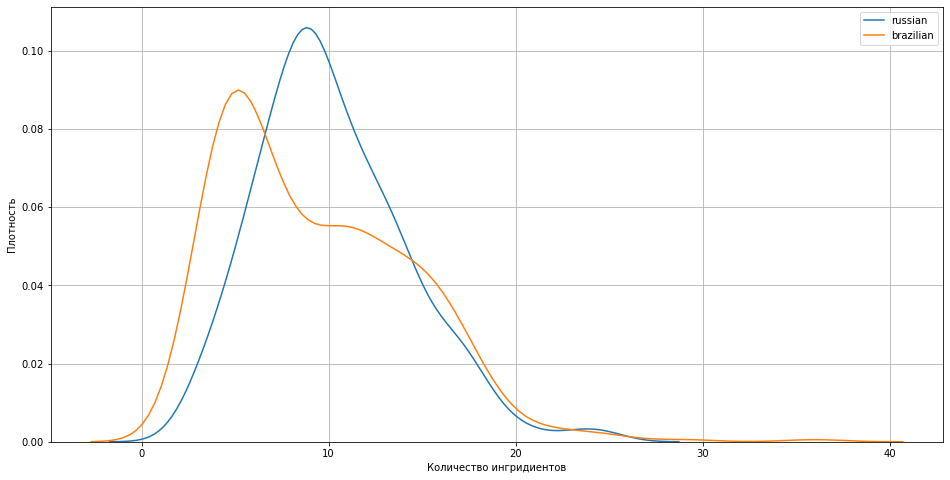

In [50]:
plt.figure(figsize=(16, 8))
fig = sns.kdeplot(cuisine1_df["ingredients_num"], label = cuisine1)
fig = sns.kdeplot(cuisine2_df["ingredients_num"], label = cuisine2)        
fig.set(xlabel=u'Количество ингридиентов', ylabel=u'Плотность')    
plt.grid()
plt.show()

Видим, что они значительно отличаются. Мы хотим оценить, из скольки ингридиентов в среднем состоят блюда наших кухонь, но так как данных в нашем датасете мало, то искать среднее не совсем правильно. Лучше как раз таки воспользоваться бутстрэпом.

In [51]:
def get_bootstrap_samples(data, n_samples):
    """Функция для генерации n_samples подвыборок с помощью бутстрэпа"""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [52]:
def stat_intervals(stat, alpha):
    """Функция для интервальной оценки"""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries, 4)

In [53]:
cuisine1_ingridients = cuisine1_df["ingredients_num"].values
cuisine2_ingridients = cuisine2_df["ingredients_num"].values

In [54]:
np.random.seed(42)

In [55]:
cuisine1_ingridients.shape

(489,)

In [56]:
get_bootstrap_samples(cuisine1_ingridients, 5000).shape

(5000, 489)

In [57]:
cuisine1_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine1_ingridients, 5000)]
cuisine2_ingridients_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(cuisine2_ingridients, 5000)]

In [64]:
print ("{} ingridients number:  mean interval".format(cuisine1),  stat_intervals(cuisine1_ingridients_scores, 0.05))
print ("{} ingridients number:  mean interval".format(cuisine2),  stat_intervals(cuisine2_ingridients_scores, 0.05))

russian ingridients number:  mean interval [ 9.8691 10.593 ]
brazilian ingridients number:  mean interval [8.9634 9.8691]


In [63]:
print("""В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в {} кухне будет лежать в промежутке между {r[0]} и {r[1]},  в то время как в {} в среднем от {b[0]} до {b[1]}"""
.format(cuisine1, cuisine2, r=stat_intervals(cuisine1_ingridients_scores, 0.05), b=stat_intervals(cuisine2_ingridients_scores, 0.05)))

В итоге мы получили, что с 95% вероятностью среднее число ингридиентов в russian кухне будет лежать в промежутке между 9.8691 и 10.593,  в то время как в brazilian в среднем от 8.9634 до 9.8691


Отлично! Мы увидели, в каких сллучаях можно пользоваться бутстрэпом. Теперь взглянем на следующую модель

# DT

In [65]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [66]:
DT_ans = DT.predict(X_test)

In [67]:
print_metrics(y_test, DT_ans)

Accuracy ~ 0.6122
F1_score ~ 0.4924


Результаты неутешительны, но мы попробуем улучшить их с помощью Бэггинга

# Bagging

In [68]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [69]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    index = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0])
    DT.fit(X_train[index], y_train[index])
    answer[i] = DT.predict(X_test)

In [70]:
bagging_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [71]:
answer.shape

(10, 13125)

In [72]:
answer[:, 3]

array([ 9,  9,  9,  6,  9, 11,  9, 10, 17,  9])

In [73]:
np.bincount(answer[:, 3]).argmax()

9

In [74]:
print_metrics(y_test, bagging_dt_answer)

Accuracy ~ 0.6896
F1_score ~ 0.5816


Наши метрики значительно улучшились. Но попробуем ещё сильнее их улучшить. Будем сэмплировать не объекты, а признаки, то есть воспользуемся методом случайных подпространств (RSM)

# RSM 

In [75]:
n_estimators = 10
answer = np.zeros((n_estimators, X_test.shape[0]), dtype=int)

In [76]:
for i in tqdm_notebook(range(n_estimators)):
    DT = DecisionTreeClassifier()
    features = np.random.choice(np.arange(X_train.shape[1]), X_train.shape[1] // 2, replace=False)
    DT.fit(X_train[:, features], y_train)
    answer[i] = DT.predict(X_test[:, features])

In [77]:
rsm_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [78]:
print_metrics(y_test, rsm_dt_answer)

Accuracy ~ 0.716
F1_score ~ 0.6106


Точность значительно выросла, при этом мы видим, что на этот метод ушло гораздо меньше времени, чем на простой Бэггинг.

Теперь введём стандартную модель Random Forest,в которой используются и идеи Бустинга и идеи Бутстрэпа

# Random Forest

In [79]:
class RandomForest():
    
    def __init__(self, n_estimators=20, max_depth=None, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees_ = [] # 
        self.features_idx = []
        self.random_state = random_state

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        for t in tqdm_notebook(range(self.n_estimators)):               
            # выбираем базовый алгоритм - дерево
            tree = DecisionTreeClassifier(max_depth=self.max_depth)
            # сэмплируем объекты
            index = np.random.choice(np.arange(X.shape[0]), X.shape[0])
            # сэмплируем признаки
            features = np.random.choice(np.arange(X.shape[1]), X.shape[1] // 2, replace=False)
            # обучаем
            tree.fit(X[index][:, features], y[index])
            # добавляем алгоритм к ансамблю
            self.trees_.append(tree)
            # добавляем признаки
            self.features_idx.append(features)
                   
        return self
    
    def predict(self, X):
        answer = np.zeros((len(self.trees_), X.shape[0]), dtype=int)
        # добавляем прогнозы деревьев
        for t in range(len(self.trees_)):
            answer[t] = self.trees_[t].predict(X[:, self.features_idx[t]])
            
        return np.array([np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])])

In [80]:
RF = RandomForest()
RF.fit(X_train, y_train)

In [81]:
RF_ans = RF.predict(X_test)

In [82]:
print_metrics(y_test, RF_ans)

Accuracy ~ 0.7301
F1_score ~ 0.6236


Видим, что метрики улучшились ещё сильнее.

# Теперь рассмотрим новый датасет

In [83]:
from sklearn.metrics import mean_squared_error as mse

In [87]:
wine = pd.read_csv("winequality-red.csv")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [88]:
X = wine.values[:, :-1]
y = wine.values[:, -1]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(wine.values[:, :-1], wine.values[:, -1], test_size=0.33, random_state=42)

## Рассмотрим метод градиентного бустинга

In [90]:
class GradientBoosting():
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42):
            
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones(len(y))
        self.loss_by_iter = [] # функция потерь на каждой итерации
        self.trees_ = []
        self.random_state = random_state
        
    def mse_grad(self, y, p):
        # написать градиент
        return 2. * (p - y) / len(y)

    
    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)
        prediction = b.copy()
        for t in tqdm_notebook(range(self.n_estimators)):               
            # считаем - антиградиент
            resid = -self.mse_grad(y, prediction)
            # выбираем базовый алгоритм
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # обучаемся на векторе антиградиента
            tree.fit(X, resid)
            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X)
            #добавляем дерево в ансамбль
            self.trees_.append(tree)
            # обновляем текущее приближение (lr * b)
            prediction += self.learning_rate * b
            
            # обновляем лосс на обучении (опционально)
            self.loss_by_iter.append(mse(y, prediction))
            
        return self
    
    def predict(self, X):
        # сначала инициализируем прогноз на тестовой выборке – 
        # это просто вектор из средних значений ответов на обучении
        pred = np.ones(X.shape[0]) * np.mean(self.y)
        # добавляем прогнозы деревьев * lr
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X)
            
        return pred

In [93]:
tree = GradientBoosting(n_estimators=100, learning_rate=1., max_depth=None)
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.5712805233507933

Видим, что ошибка довольно большая, но что происходит на обычном DecisonTreeClassifier?

In [95]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
mse(y_test, tree.predict(X_test))

0.7140151515151515

Видим, что ошибка гораздо больше, и бустинг действительно улучшил предсказание. Идеи градиентного бустинга используются в моделях lightgbm. Посмотрим, что нам даст LGBMRegressor

In [101]:
from lightgbm import LGBMRegressor

LGBM = LGBMRegressor(n_estimators=500)
LGBM.fit(X_train, y_train.ravel())
LGBM_ans = LGBM.predict(X_test)
mse(y_test, LGBM_ans)

0.41309086015684054

Видим, что mse уменьшился. Это произошло из-за использования в lgbm, помимо градиентного бустинга, методов бэггинга и RSM

# Итоги

Конечно, разные модели подходят для разных ситуаций: некоторые лучше, некоторые хуже, но мы можем сделать вывод, что в ансамблях перечисленные модели работают гораздо лучше, что и было продемонстрировано всеми результатами выше. Очень полезно в решении аналитических задач использовать такие методы, как Бэггинг, Стэкинг, RSM и градиентный бустинг. Также важно уметь правильно подбирать параметры, и понимать, какие модели предназначены для тех или иных вариантов задач